In [10]:
import numpy as np
import pandas as pd
from random import shuffle
import warnings

import utils.params as params

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.decomposition import PCA

from sklearn_extensions.extreme_learning_machines.elm import GenELMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,log_loss,auc,recall_score,roc_curve

import matplotlib.pyplot as plt

In [13]:
%matplotlib inline

In [31]:
warnings.filterwarnings("ignore",category=DeprecationWarning)

def gen_csv(data,labels,outfile='./output/sonitrol_16bit_binary.csv'):
    """
    Method for generating CSV data from embedding vectors
    :param: data - np array nrecords x nfeatures for each audio file
    :param: labels - list of labels (must be binary 0/1!!!)
    :param: outfile - csv filename to save out to
    """
    df_check = pd.DataFrame(data)
    labs_text_binary = ['indistinguishable' if labels[x]<1 else 'distinguishable' for x in range(len(labels))]
    df_check['label'] = pd.Series(labs_text_binary,index=df_check.index)
    df_check.to_csv(outfile)
    return

def load_data(npz_file,norm=True):
    """
    :param: npz_file - file path to npz file containing
            data and labels 
    :param: norm - Boolean value specifying if it should
            return normalized data. Assumes nrecords is
            along axis 0
    :return: data,label arrays [nrecords,nfeatures]
    """
    arr = np.load(npz_file)
    if norm:
        data,labs = arr['data'],arr['labels']
        ndata = (data-np.mean(data,axis=0))/np.std(data)
        return ndata,labs
    else:
        return arr['data'],arr['labels']
    
def format_labels_binary(labels,class_set):
    """
    Method for converting raw numberical labels (1-8,101-115)
    to binary 0/1 labels.
    
    :param: labels - list of raw labels
    :param: class_set - set of raw labels defined as '0' or indist.
    :return: list of labels in same order containing (0,1)
    """
    return [0 if labels[x] in iset else 1 for x in range(len(labels))]

def train_and_eval(xs,ys,clf,xgb=False,folds=10):
    """
    Method for training a classifier over a defined number of folds
    (default ten) using the Stratified K-Fold method. Stratefied k-
    fold ensures that the class distribution is preserved within each
    fold
    
    :param: xs - np array (nrecords x nfeatures) to be split into k-fold 
            train/val sets
    :param: ys - corresponding list of labels in correct order
    :param: clf - sklearn classifier to fit data to, initialized with 
            specific params
    :param: xgb - boolean value specifying if using XGBoost classifier
            or not. XGBoost must be run in a slightly different manner
    :param: folds - int value specifying number of stratified k-folds
    :return: dict of accuracy metrics from the training/validation
    """
    
    # Define Metric Lists:
    clf_acc = []
    clf_log = []
    clf_auc = []
    clf_rec = []
    
    # Set Up K-Folds
    skf = StratifiedKFold(n_splits=folds, shuffle=True)
    
    # Train and Eval Folds
    for train_idx,test_idx in skf.split(xs,ys):
        # Train/Test Splits
        x_train,y_train = xs[train_idx],np.array(ys)[train_idx]
        x_test,y_test = xs[test_idx],np.array(ys)[test_idx]
    
        # Fit Classifier
        clf_temp = clf
        if xgb:
            clf_temp.fit(x_train,
                         y_train,
                         eval_set=[(x_test, y_test)],
                         verbose=False,
                         eval_metric='logloss',
                         early_stopping_rounds=50)
        else:
            clf_temp.fit(x_train,y_train)
        
        # Gen Eval Stats
        acc = accuracy_score(y_test,clf_temp.predict(x_test))
        ll = log_loss(y_test,clf_temp.predict_proba(x_test))
        rec = recall_score(y_test,clf_temp.predict(x_test))
        fpr, tpr, thresholds = roc_curve(y_test, clf_temp.predict(x_test), pos_label=1)
        mauc = auc(fpr,tpr)
        
        #Append to Lists
        clf_acc.append(acc)
        clf_log.append(ll)
        clf_rec.append(rec)
        clf_auc.append(mauc)
        
        # Print Info to Console
        print "Fold: "+str(len(clf_auc))
        print "Acc: "+str(acc)+" | Logloss: "+str(ll)+" | Recall: "+str(rec)+" | AUC: "+str(mauc)
       
    return {'acc':clf_acc,'log':clf_log,'auc':clf_auc,'rec':clf_rec} 

def plot_training_results(clf_metrics,clf_names,nfolds=10,style='acc'):
    """
    Method for plotting training results for a list of classifiers
    :param: clf_metrics - dictionary of metrics for the trained classifier
    :param: clf_names - list of classifier names (this should be switched)
            soon
    :param: nfolds - number of folds that the training was performed over
    :param: style - style of plot, such as acc, rec, log, auc
    """

    xrng = np.linspace(1,nfolds,nfolds)
    colors = ['darkred','darkblue','darkgreen']
    scolors = ['red','blue','green']
    cidx = 0 
    
    plt.figure(figsize=(15,7))
    plt.title("Training Metrics - "+style,size=24)
    
    for clf in clf_metrics:
        plt.plot(xrng,clf[style],color=colors[cidx%len(colors)])
        plt.hlines(np.mean(clf[style]),1,len(xrng),
                   color=scolors[cidx],linestyle="--",
                   label=clf_names[cidx]+" - "+"{:3.3f}".format(np.mean(clf[style])))
        cidx+=1

    plt.grid(color="gray",linestyle="--")
    plt.ylabel(style,size=20)
    plt.xlabel("K-Fold Iteration",size=20)
    plt.yticks(size=20)
    plt.xticks(size=20)
    plt.axis([1,nfolds,0,1])

    plt.legend(prop={'size': 20})
    plt.show()
    
    return

In [18]:
# TRAIN AND VALIDATE MODELS

#DEFINE DATASET AND BINARY LABEL CRITERIA
iset = set([1,2,3,4,5,6,7,8])
dfile = "./output/embeddings_16bit.npz"

# LOAD DATA AND CONVERT TO BINARY
ndata,labels = load_data(dfile)
blabels = format_labels_binary(labels,iset)

# XGBOOST
print "-- Training XGBoost"
clf_xgb = xgb.XGBClassifier(max_depth=13,
                            n_estimators=1800,
                            min_child_weight=1,
                            learning_rate=0.04,
                            subsample=0.8,
                            colsample_bytree=0.6,
                            gamma= 2)
xgb_metrics = train_and_eval(ndata,blabels,clf_xgb,xgb=True,folds=10)

# MLP
print "-- Training MLP"
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,100,100,100),batch_size=64)
mlp_metrics = train_and_eval(ndata,blabels,clf_mlp)

# RANDOM FOREST
print "-- Training Random Forest"
clf_rf = RandomForestClassifier(n_estimators=1800,
                                max_depth=13)
rf_metrics = train_and_eval(ndata,blabels,clf_rf)

-- Training XGBoost
Fold: 1
Acc: 0.8458904109589042 | Logloss: 0.3640107763245421 | Recall: 0.8367278638362976 | AUC: 0.8367278638362975
Fold: 2
Acc: 0.839041095890411 | Logloss: 0.37005836825039595 | Recall: 0.8316599732262383 | AUC: 0.8316599732262383
Fold: 3
Acc: 0.839041095890411 | Logloss: 0.353307736874877 | Recall: 0.8326161790017211 | AUC: 0.8326161790017211
Fold: 4
Acc: 0.8184931506849316 | Logloss: 0.40927970878881953 | Recall: 0.8078504494167145 | AUC: 0.8078504494167146
Fold: 5
Acc: 0.8424657534246576 | Logloss: 0.34394929655636214 | Recall: 0.8308471983170778 | AUC: 0.8308471983170779
Fold: 6
Acc: 0.7835051546391752 | Logloss: 0.41440807168669613 | Recall: 0.7687469879518072 | AUC: 0.7687469879518073
Fold: 7
Acc: 0.8144329896907216 | Logloss: 0.40808775048715756 | Recall: 0.7998072289156626 | AUC: 0.7998072289156627
Fold: 8
Acc: 0.8762886597938144 | Logloss: 0.34867830667004657 | Recall: 0.8648915662650603 | AUC: 0.8648915662650603
Fold: 9
Acc: 0.8281786941580757 | Logloss

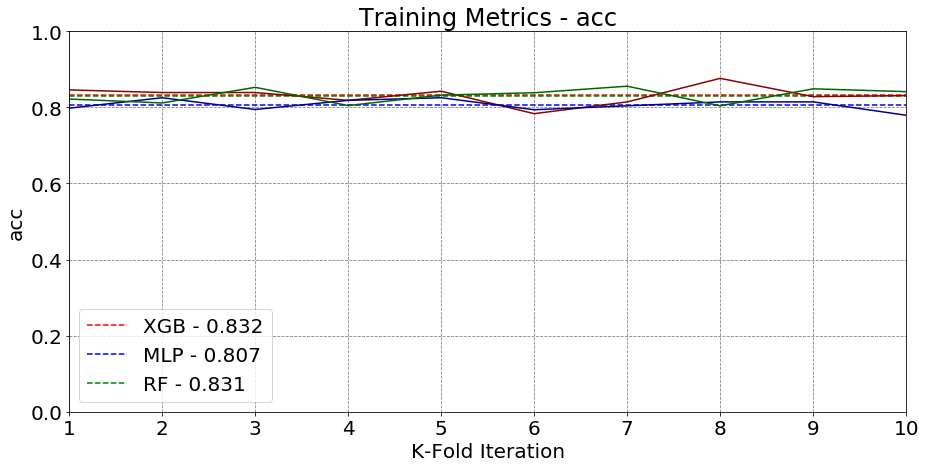

In [23]:
plot_training_results([xgb_metrics,mlp_metrics,rf_metrics],['XGB','MLP','RF'],style='acc')

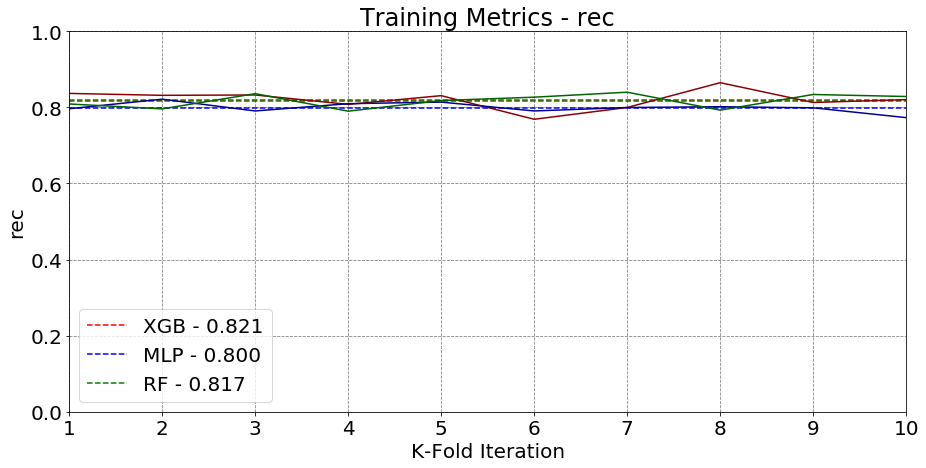

In [24]:
plot_training_results([xgb_metrics,mlp_metrics,rf_metrics],['XGB','MLP','RF'],style='rec')

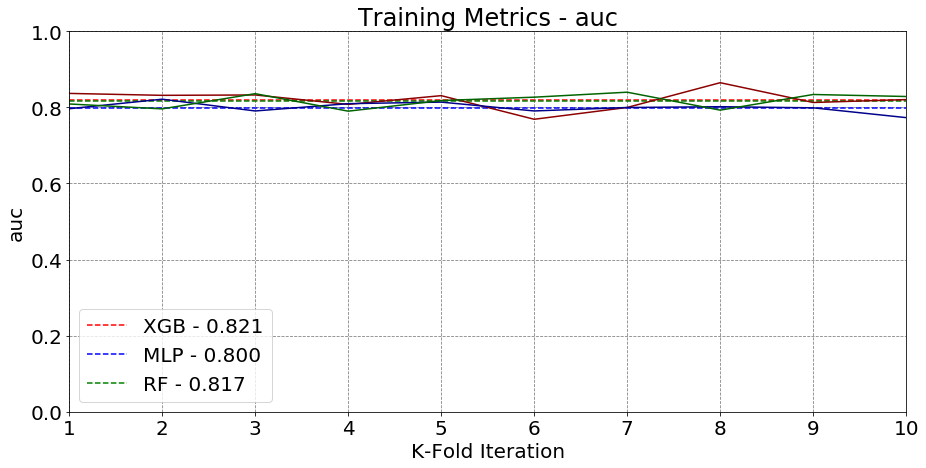

In [29]:
plot_training_results([xgb_metrics,mlp_metrics,rf_metrics],['XGB','MLP','RF'],style='auc')

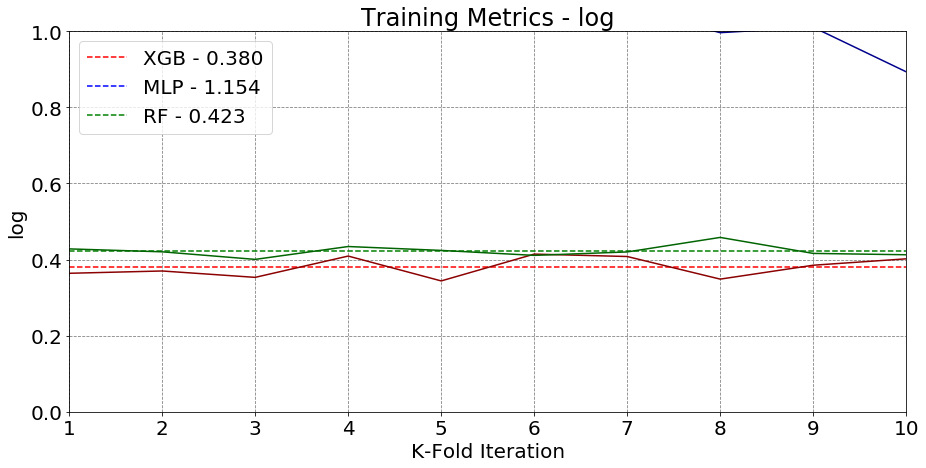

In [27]:
plot_training_results([xgb_metrics,mlp_metrics,rf_metrics],['XGB','MLP','RF'],style='log')